<a href="https://colab.research.google.com/github/kashindra-mahato/SOC-support-system/blob/kashindra/authlog2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
pd.options.display.max_colwidth = 100
pd.set_option('display.precision', 3)

In [4]:
auth = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DATASET/auth.csv')

In [5]:
auth1 = auth[:5000]

In [6]:
auth1.Event.head()

0               pam_unix(cron:session): session closed for user root
1    pam_unix(cron:session): session opened for user root by (uid=0)
2               pam_unix(cron:session): session closed for user root
3                      Connection closed by 122.225.103.87 [preauth]
4                      Connection closed by 122.225.103.87 [preauth]
Name: Event, dtype: object

In [7]:
# Remove numbers and special-characters from Event
auth1['Event'] = auth1['Event'].str.replace('\d+', '')
auth1['Event'] = auth1['Event'].str.replace(r'[^\w\s]+', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

In [8]:
auth1.Event.head()

0           pam_unixcronsession session closed for user root
1    pam_unixcronsession session opened for user root by uid
2           pam_unixcronsession session closed for user root
3                              Connection closed by  preauth
4                              Connection closed by  preauth
Name: Event, dtype: object

In [9]:
# Remove stop words from Event
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

all_stopwords = stopwords.words('english')
all_stopwords.extend(['pam_unixcronsession', 'string', 'from', 'bye', 'for', 'port', 'sshd', 'ssh', 'root', 'preauth'])
auth1.Event = auth1.Event.str.lower()
auth1['Event'] = auth1['Event'].apply(lambda x: ' '.join([word for word in x.split() if word not in (all_stopwords)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [10]:
auth1.Event.head(50)

0                                session closed user
1                            session opened user uid
2                                session closed user
3                                  connection closed
4                                  connection closed
5                                  connection closed
6                            session opened user uid
7                                session closed user
8                            session opened user uid
9                                session closed user
10                                invalid user admin
11         input_userauth_request invalid user admin
12                               received disconnect
13                            receive identification
14                           session opened user uid
15                               session closed user
16                            receive identification
17                           session opened user uid
18                               session close

In [11]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity


def build_vectorizer(sentences, vocab=None, min_df=0.0, max_df=1.0, ngram_range=(1,1)):
  # Build count vectorizer
  count_vectorzier = CountVectorizer(max_df=max_df, min_df=min_df,vocabulary=vocab, ngram_range=(1,1))
  cvec = count_vectorzier.fit(sentences)

  # Get feature names
  feature_names = cvec.get_feature_names_out()

  # Get bag-of-words and analyze
  bag_of_words = cvec.transform(sentences)
  df_bag_of_words = pd.DataFrame(bag_of_words.todense(),columns=feature_names)

  # Transform bag-of-words into tf-idf matrix
  transformer = TfidfTransformer()
  tfidf = transformer.fit_transform(bag_of_words)

  # Find most popular words and highest weights
  word_cnts = np.asarray(bag_of_words.sum(axis=0)).ravel().tolist() # for each word in column, sum all row counts
  df_cnts = pd.DataFrame({'word':feature_names, 'count':word_cnts})
  df_cnts = df_cnts.sort_values('count', ascending=False)

  # Build word weights as a list and sort them
  weights = np.asarray(tfidf.mean(axis=0)).ravel().tolist()
  df_weights = pd.DataFrame({'word': feature_names,'weight':weights})
  df_weights = df_weights.sort_values('weight', ascending=False)

  df_weights = df_weights.merge(df_cnts, on='word', how='left')
  df_weights = df_weights[['word','count', 'weight']]

  # Cosine similarity of sentences
  cos_sim = cosine_similarity(tfidf,tfidf)

  # Distance matrix of sentences
  samp_dist = 1 - cos_sim

  return cvec, feature_names, df_bag_of_words, tfidf, df_weights, cos_sim, samp_dist


In [12]:
sentences = auth1.Event[:1000]

In [13]:
cvec, feature_names, df_bag_of_words, tfidf, df_weights, cos_sim, sam_dist = build_vectorizer(sentences)

df_tfidf = pd.DataFrame(tfidf.todense(), columns=feature_names)
print(sentences)
print("---")
print("%d feature_names (each feature represent a distinct word)" %len(feature_names))
print(feature_names)
print("---")
print("df_tfidf[%d,%d]:"% (len(sentences), len(feature_names)))
# print(df_tfidf.to_string())
print("---")
print("df_weights:")
print(df_weights)
print("---")
print("cos_sim[%d,%d] (a sqaure matrix of length and width = len(sentences)):"%(len(sentences), len(sentences)))
print(cos_sim)

0          session closed user
1      session opened user uid
2          session closed user
3            connection closed
4            connection closed
                ...           
995     receive identification
996     receive identification
997     receive identification
998     receive identification
999     receive identification
Name: Event, Length: 1000, dtype: object
---
120 feature_names (each feature represent a distinct word)
['address' 'admin' 'altibase' 'ankit' 'app' 'appdev' 'ashish' 'attempt'
 'avconroot' 'avinash' 'barbara' 'ben' 'breakin' 'bwadmin' 'cacti' 'cant'
 'cgi' 'charlton' 'checking' 'client' 'closed' 'cms' 'connection' 'corin'
 'could' 'dbinst' 'demo' 'dev' 'disconnect' 'dmuser' 'donald' 'failed'
 'fatal' 'feng' 'ftpuser' 'get' 'getaddrinfo' 'git' 'google' 'gopher'
 'guest' 'hadoop' 'hduser' 'hjlee' 'ibmuser' 'ident' 'identification'
 'info' 'input_userauth_request' 'internetsxcn' 'invalid' 'jabber' 'jacky'
 'jenkins' 'jk' 'kevin' 'kim' 'liyang' 'mapping' 

               word  count     weight
0    identification    448  3.168e-01
1           receive    448  3.168e-01
2          received    147  1.039e-01
3        disconnect    147  1.039e-01
4              user    275  8.449e-02
..              ...    ...        ...
115             get      2  8.107e-04
116          client      2  8.107e-04
117         address      2  8.107e-04
118         nslocal      1  5.770e-04
119         unknown      1  5.218e-04

[120 rows x 3 columns]
---
di_word_freq:
identification 448
receive 448
received 147
disconnect 147
user 275
invalid 230
input_userauth_request 115
failed 105
closed 45
connection 61
session 43
getaddrinfo 69
checking 69
reverse 69
possible 69
breakin 69
mapping 69
attempt 69
internetsxcn 65
reset 38
peer 38
read 36
fatal 36
socket 36
uid 21
opened 21
oracle 10
admin 8
nagios 6
hadoop 6
svn 6
postgres 6
support 6
teamspeak 6
avconroot 6
test 4
tomcat 4
git 4
operator 4
guest 4
ftpuser 4
demo 4
webmaster 4
ts 4
cms 4
xiang 2
xliu 2
sysadm

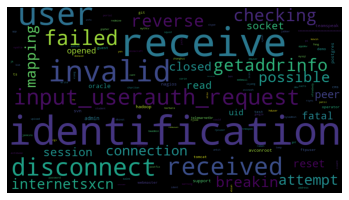

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
print(df_weights)
s_word_freq = pd.Series(df_weights['count'])
s_word_freq.index = df_weights['word']
di_word_freq = s_word_freq.to_dict()

print("---")
print("di_word_freq:")
for k,v in di_word_freq.items():
  print(k,v)

cloud = WordCloud(width=900, height=500).generate_from_frequencies(di_word_freq)
plt.imshow(cloud)
plt.axis('off')
plt.show()

In [15]:
# from sklearn.cluster import KMeans
# from sklearn.decomposition import PCA
# # Dimensionality reduction using PCA, reduce the tfidf matrix to just 2 features
# X = tfidf.todense()
# pca = PCA(n_components=2)
# pca.fit(X)
# X_pca = pca.transform(X)

# km_model = KMeans(n_clusters=3, max_iter=10, n_init=2, random_state=0)

# # K-means (from number of features in input matrix to n_clusters)
# km_model.fit(X_pca)
# df_centers = pd.DataFrame(km_model.cluster_centers_, columns=['x', 'y'])

# plt.figure(figsize=(4,4))
# plt.suptitle('PCA features colored by class; grey circles show the k-means centers')
# plt.scatter(X_pca[:, 0], X_pca[:, 1], c=km_model.labels_, s=50, cmap='jet')
# plt.scatter(df_centers['x'], df_centers['y'], c='grey', s=500, alpha=0.2);

# dy = 0.04
# for i, txt in enumerate(km_model.labels_):
#     plt.annotate(txt, (X_pca[i, 0], X_pca[i, 1] + dy))


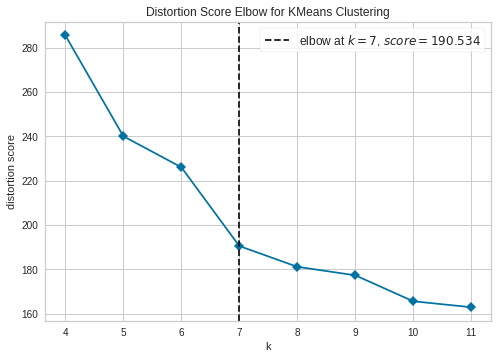

In [16]:
# Elbow method
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12), timings=False)
X = tfidf.toarray()
visualizer.fit(X)
visualizer.show()

In [17]:
# PCA
from functools import reduce
from sklearn.decomposition import PCA
pca = PCA(n_components=0.80)
pca.fit(X)
data_pca = pca.transform(X)

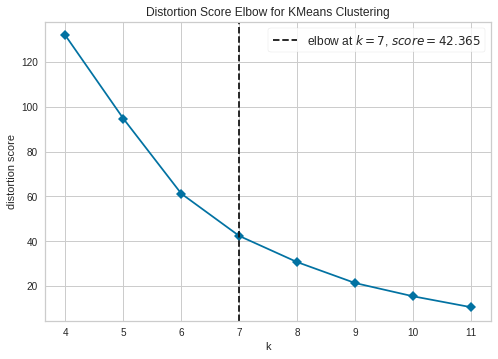

In [18]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12), timings=False)
visualizer.fit(data_pca)
visualizer.show()

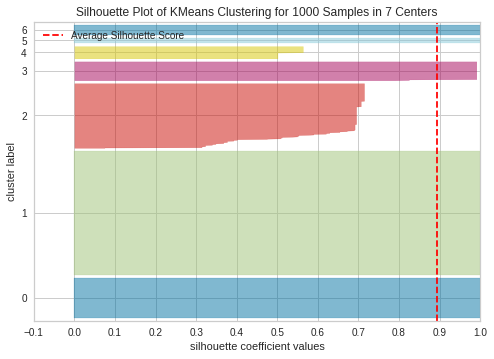

In [19]:
# Silhouette method
from yellowbrick.cluster.silhouette import SilhouetteVisualizer
model = KMeans(7, random_state=0)
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(data_pca)
visualizer.show()

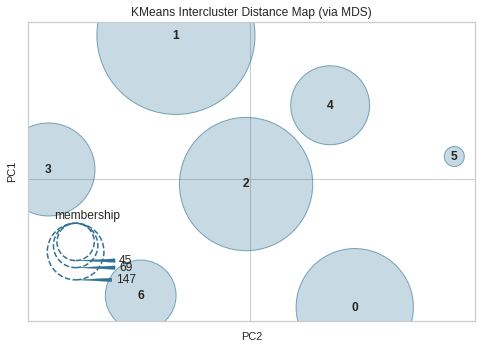

In [20]:
# Intercluster Distance Maps
from yellowbrick.cluster.icdm import InterclusterDistance
visualizer = InterclusterDistance(model, random_state=0)
visualizer.fit(data_pca)
visualizer.show()

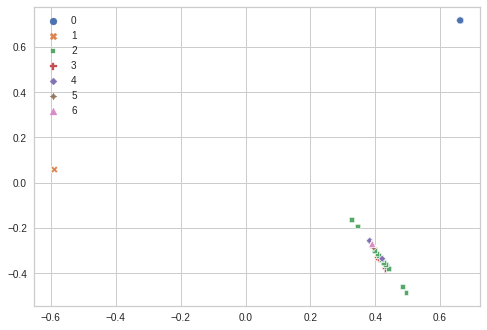

In [21]:
import seaborn as sns
import plotly.express as px

model.fit(data_pca)
# df['y_pred'] = model.predict(data_pca)
fig = px.scatter(x=data_pca[:, 0], y=data_pca[:, 1])
fig.show()

sns.scatterplot(x=data_pca[:, 0], y=data_pca[:, 1], hue=model.labels_,style=model.labels_,palette='deep',data=data_pca)


In [22]:
df = auth1[:1000]

In [23]:
df['y_pred'] = model.labels_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
centroids = model.cluster_centers_

In [25]:
# dict1 = dict(list(enumerate(centroids)))

In [26]:
df_cent = pd.DataFrame(centroids)

In [27]:
df_cent['label'] = [i for i in range(len(centroids))]

In [28]:
data_pca

array([[ 4.21416116e-01, -3.35963325e-01, -2.15264110e-01, ...,
        -1.33861219e-03,  3.46258629e-17, -5.91481546e-17],
       [ 3.95663716e-01, -2.88559917e-01, -1.73673587e-01, ...,
         7.50026978e-03, -9.96814258e-18,  6.55079632e-17],
       [ 4.21416116e-01, -3.35963325e-01, -2.15264110e-01, ...,
        -1.33861219e-03,  3.46258629e-17, -5.91481546e-17],
       ...,
       [-5.89347845e-01,  5.81308830e-02,  2.71413409e-03, ...,
         2.23796420e-04, -2.53418115e-18,  1.43619909e-18],
       [-5.89347845e-01,  5.81308830e-02,  2.71413409e-03, ...,
         2.23796420e-04, -2.53418115e-18,  1.43619909e-18],
       [-5.89347845e-01,  5.81308830e-02,  2.71413409e-03, ...,
         2.23796420e-04, -2.53418115e-18,  1.43619909e-18]])

In [29]:
df_data_pca = pd.DataFrame(data_pca)

In [30]:
df_data_pca['label'] = model.predict(data_pca)

In [31]:
df_data_pca

,0,1,2,3,4,5,6,7,8,9,10,11,label
0,0.421,-0.336,-0.215,0.288,7.172e-01,-1.931e-02,6.848e-02,0.414,-5.124e-03,-1.339e-03,3.463e-17,-5.915e-17,4
1,0.396,-0.289,-0.174,0.081,4.960e-01,7.430e-01,-1.282e-01,-0.235,1.461e-02,7.500e-03,-9.968e-18,6.551e-17,5
2,0.421,-0.336,-0.215,0.288,7.172e-01,-1.931e-02,6.848e-02,0.414,-5.124e-03,-1.339e-03,3.463e-17,-5.915e-17,4
3,0.383,-0.256,-0.050,0.634,4.000e-01,-5.469e-01,-8.007e-02,-0.281,1.082e-02,5.599e-03,-2.433e-17,8.037e-17,4
4,0.383,-0.256,-0.050,0.634,4.000e-01,-5.469e-01,-8.007e-02,-0.281,1.082e-02,5.599e-03,-2.433e-17,8.037e-17,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.589,0.058,0.003,-0.005,6.407e-05,-4.252e-04,-9.273e-04,0.001,3.249e-04,2.238e-04,-2.534e-18,1.436e-18,1
996,-0.589,0.058,0.003,-0.005,6.407e-05,-4.252e-04,-9.273e-04,0.001,3.249e-04,2.238e-04,-2.534e-18,1.436e-18,1
997,-0.589,0.058,0.003,-0.005,6.407e-05,-4.252e-04,-9.273e-04,0.001,3.249e-04,2.238e-04,-2.534e-18,1.436e-18,1
998,-0.589,0.058,0.003,-0.005,6.407e-05,-4.252e-04,-9.273e-04,0.001,3.249e-04,2.238e-04,-2.534e-18,1.436e-18,1


In [32]:
df_data_pca_join = df_data_pca.join(df_cent,on='label', how='left',lsuffix='_pca', rsuffix='_cent')

In [33]:
df_data_pca_join

,0_pca,1_pca,2_pca,3_pca,4_pca,5_pca,6_pca,7_pca,8_pca,9_pca,...,3_cent,4_cent,5_cent,6_cent,7_cent,8_cent,9_cent,10_cent,11_cent,label_cent
0,0.421,-0.336,-0.215,0.288,7.172e-01,-1.931e-02,6.848e-02,0.414,-5.124e-03,-1.339e-03,...,0.465,5.551e-01,-2.890e-01,-7.443e-03,0.058,3.026e-03,2.207e-03,4.495e-18,1.216e-17,4
1,0.396,-0.289,-0.174,0.081,4.960e-01,7.430e-01,-1.282e-01,-0.235,1.461e-02,7.500e-03,...,0.081,4.960e-01,7.430e-01,-1.282e-01,-0.235,1.461e-02,7.500e-03,-9.968e-18,6.551e-17,5
2,0.421,-0.336,-0.215,0.288,7.172e-01,-1.931e-02,6.848e-02,0.414,-5.124e-03,-1.339e-03,...,0.465,5.551e-01,-2.890e-01,-7.443e-03,0.058,3.026e-03,2.207e-03,4.495e-18,1.216e-17,4
3,0.383,-0.256,-0.050,0.634,4.000e-01,-5.469e-01,-8.007e-02,-0.281,1.082e-02,5.599e-03,...,0.465,5.551e-01,-2.890e-01,-7.443e-03,0.058,3.026e-03,2.207e-03,4.495e-18,1.216e-17,4
4,0.383,-0.256,-0.050,0.634,4.000e-01,-5.469e-01,-8.007e-02,-0.281,1.082e-02,5.599e-03,...,0.465,5.551e-01,-2.890e-01,-7.443e-03,0.058,3.026e-03,2.207e-03,4.495e-18,1.216e-17,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.589,0.058,0.003,-0.005,6.407e-05,-4.252e-04,-9.273e-04,0.001,3.249e-04,2.238e-04,...,-0.005,6.407e-05,-4.252e-04,-9.273e-04,0.001,3.249e-04,2.238e-04,-2.534e-18,1.436e-18,1
996,-0.589,0.058,0.003,-0.005,6.407e-05,-4.252e-04,-9.273e-04,0.001,3.249e-04,2.238e-04,...,-0.005,6.407e-05,-4.252e-04,-9.273e-04,0.001,3.249e-04,2.238e-04,-2.534e-18,1.436e-18,1
997,-0.589,0.058,0.003,-0.005,6.407e-05,-4.252e-04,-9.273e-04,0.001,3.249e-04,2.238e-04,...,-0.005,6.407e-05,-4.252e-04,-9.273e-04,0.001,3.249e-04,2.238e-04,-2.534e-18,1.436e-18,1
998,-0.589,0.058,0.003,-0.005,6.407e-05,-4.252e-04,-9.273e-04,0.001,3.249e-04,2.238e-04,...,-0.005,6.407e-05,-4.252e-04,-9.273e-04,0.001,3.249e-04,2.238e-04,-2.534e-18,1.436e-18,1


In [34]:
df_pca_1 = df_data_pca_join.loc[:, "0_pca":"label_pca"]
df_pca_1.drop('label_pca', axis=1, inplace=True)
df_cent_1 = df_data_pca_join.loc[:, "0_cent":"label_cent"]
df_cent_1.drop('label_cent', axis=1, inplace=True)

In [35]:
display(df_pca_1)
display(df_cent_1)

,0_pca,1_pca,2_pca,3_pca,4_pca,5_pca,6_pca,7_pca,8_pca,9_pca,10_pca,11_pca
0,0.421,-0.336,-0.215,0.288,7.172e-01,-1.931e-02,6.848e-02,0.414,-5.124e-03,-1.339e-03,3.463e-17,-5.915e-17
1,0.396,-0.289,-0.174,0.081,4.960e-01,7.430e-01,-1.282e-01,-0.235,1.461e-02,7.500e-03,-9.968e-18,6.551e-17
2,0.421,-0.336,-0.215,0.288,7.172e-01,-1.931e-02,6.848e-02,0.414,-5.124e-03,-1.339e-03,3.463e-17,-5.915e-17
3,0.383,-0.256,-0.050,0.634,4.000e-01,-5.469e-01,-8.007e-02,-0.281,1.082e-02,5.599e-03,-2.433e-17,8.037e-17
4,0.383,-0.256,-0.050,0.634,4.000e-01,-5.469e-01,-8.007e-02,-0.281,1.082e-02,5.599e-03,-2.433e-17,8.037e-17
...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.589,0.058,0.003,-0.005,6.407e-05,-4.252e-04,-9.273e-04,0.001,3.249e-04,2.238e-04,-2.534e-18,1.436e-18
996,-0.589,0.058,0.003,-0.005,6.407e-05,-4.252e-04,-9.273e-04,0.001,3.249e-04,2.238e-04,-2.534e-18,1.436e-18
997,-0.589,0.058,0.003,-0.005,6.407e-05,-4.252e-04,-9.273e-04,0.001,3.249e-04,2.238e-04,-2.534e-18,1.436e-18
998,-0.589,0.058,0.003,-0.005,6.407e-05,-4.252e-04,-9.273e-04,0.001,3.249e-04,2.238e-04,-2.534e-18,1.436e-18


,0_cent,1_cent,2_cent,3_cent,4_cent,5_cent,6_cent,7_cent,8_cent,9_cent,10_cent,11_cent
0,0.402,-0.295,-0.131,0.465,5.551e-01,-2.890e-01,-7.443e-03,0.058,3.026e-03,2.207e-03,4.495e-18,1.216e-17
1,0.396,-0.289,-0.174,0.081,4.960e-01,7.430e-01,-1.282e-01,-0.235,1.461e-02,7.500e-03,-9.968e-18,6.551e-17
2,0.402,-0.295,-0.131,0.465,5.551e-01,-2.890e-01,-7.443e-03,0.058,3.026e-03,2.207e-03,4.495e-18,1.216e-17
3,0.402,-0.295,-0.131,0.465,5.551e-01,-2.890e-01,-7.443e-03,0.058,3.026e-03,2.207e-03,4.495e-18,1.216e-17
4,0.402,-0.295,-0.131,0.465,5.551e-01,-2.890e-01,-7.443e-03,0.058,3.026e-03,2.207e-03,4.495e-18,1.216e-17
...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.589,0.058,0.003,-0.005,6.407e-05,-4.252e-04,-9.273e-04,0.001,3.249e-04,2.238e-04,-2.534e-18,1.436e-18
996,-0.589,0.058,0.003,-0.005,6.407e-05,-4.252e-04,-9.273e-04,0.001,3.249e-04,2.238e-04,-2.534e-18,1.436e-18
997,-0.589,0.058,0.003,-0.005,6.407e-05,-4.252e-04,-9.273e-04,0.001,3.249e-04,2.238e-04,-2.534e-18,1.436e-18
998,-0.589,0.058,0.003,-0.005,6.407e-05,-4.252e-04,-9.273e-04,0.001,3.249e-04,2.238e-04,-2.534e-18,1.436e-18


In [36]:
list1 = df_pca_1.to_numpy().tolist()
list2 = df_cent_1.to_numpy().tolist()

In [37]:
from scipy.spatial import distance
distances = []
for i in range(len(list1)):
  dist = distance.euclidean(list1[i],list2[i])
  distances.append(dist)

In [38]:
df['distance'] = distances

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [39]:
df

,Unnamed: 0,Time,Hostname,Process,Event,y_pred,distance
0,0,Nov 30 06:39:00,ip-172-31-27-153,CRON[21882],session closed user,4,5.209e-01
1,1,Nov 30 06:47:01,ip-172-31-27-153,CRON[22087],session opened user uid,5,1.153e-16
2,2,Nov 30 06:47:03,ip-172-31-27-153,CRON[22087],session closed user,4,5.209e-01
3,3,Nov 30 07:07:14,ip-172-31-27-153,sshd[22116],connection closed,4,4.983e-01
4,4,Nov 30 07:07:35,ip-172-31-27-153,sshd[22118],connection closed,4,4.983e-01
...,...,...,...,...,...,...,...
995,995,Dec 1 02:20:07,ip-172-31-27-153,sshd[23844],receive identification,1,6.673e-16
996,996,Dec 1 02:20:08,ip-172-31-27-153,sshd[23845],receive identification,1,6.673e-16
997,997,Dec 1 02:20:09,ip-172-31-27-153,sshd[23846],receive identification,1,6.673e-16
998,998,Dec 1 02:20:10,ip-172-31-27-153,sshd[23847],receive identification,1,6.673e-16


In [40]:
def modified_zscore(data, consistency_correction=1.4826):
    
    median = np.median(data)
    
    deviation_from_med = np.array(data) - median

    mad = np.median(np.abs(deviation_from_med))
    mod_zscore = deviation_from_med/(consistency_correction*mad)
    return mod_zscore, mad

In [41]:
mod_zscore, mad = modified_zscore(df['distance'])

In [42]:
df['mod_zscore'] = mod_zscore.tolist()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [43]:
df

,Unnamed: 0,Time,Hostname,Process,Event,y_pred,distance,mod_zscore
0,0,Nov 30 06:39:00,ip-172-31-27-153,CRON[21882],session closed user,4,5.209e-01,1.052e+15
1,1,Nov 30 06:47:01,ip-172-31-27-153,CRON[22087],session opened user uid,5,1.153e-16,-1.115e+00
2,2,Nov 30 06:47:03,ip-172-31-27-153,CRON[22087],session closed user,4,5.209e-01,1.052e+15
3,3,Nov 30 07:07:14,ip-172-31-27-153,sshd[22116],connection closed,4,4.983e-01,1.006e+15
4,4,Nov 30 07:07:35,ip-172-31-27-153,sshd[22118],connection closed,4,4.983e-01,1.006e+15
...,...,...,...,...,...,...,...,...
995,995,Dec 1 02:20:07,ip-172-31-27-153,sshd[23844],receive identification,1,6.673e-16,0.000e+00
996,996,Dec 1 02:20:08,ip-172-31-27-153,sshd[23845],receive identification,1,6.673e-16,0.000e+00
997,997,Dec 1 02:20:09,ip-172-31-27-153,sshd[23846],receive identification,1,6.673e-16,0.000e+00
998,998,Dec 1 02:20:10,ip-172-31-27-153,sshd[23847],receive identification,1,6.673e-16,0.000e+00


In [44]:
def plot_anomaly(data, threshold):
    data = data.copy().sort_values(ascending=False).values
    ranks = np.linspace(1, len(data), len(data))
    mask_outliers = (data > threshold)
    
    plt.figure(dpi=100)
    plt.plot(ranks[mask_outliers], data[mask_outliers],'o', color='r',label='anomalies')
    plt.plot(ranks[~mask_outliers], data[~mask_outliers],'o', color='b', label='normal')
    # plt.axhline(threshold,color='r',label='threshold', alpha=0.5)
    plt.legend(loc = 'upper right')
    plt.title('Modified z-score vs. Log Event', fontweight='bold')
    # plt.xticks(np.arange(0, 21, step=2.0))
    plt.xlabel('Event')
    plt.ylabel('Modified z-score')
    plt.show()

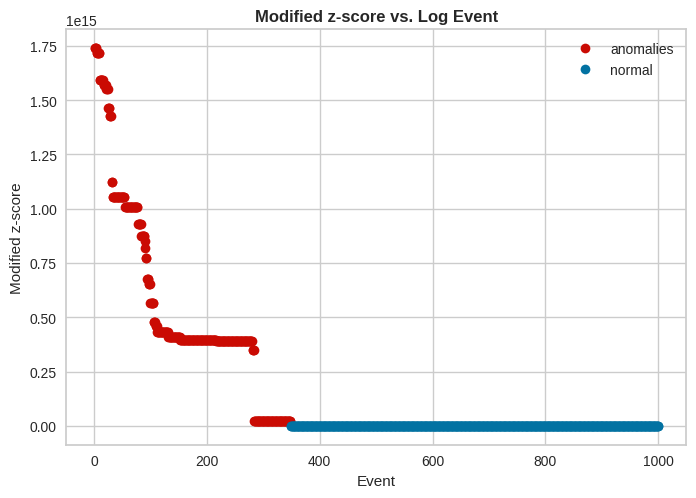

In [45]:
plot_anomaly(df['mod_zscore'],3)

In [46]:
df.loc[df.mod_zscore>3].Event.unique()

array(['session closed user', 'connection closed', 'invalid user admin',
       'input_userauth_request invalid user admin',
       'warning cant get client address connection reset peer',
       'could write ident unknown', 'could write ident',
       'invalid user guest', 'input_userauth_request invalid user guest',
       'invalid user support',
       'input_userauth_request invalid user support',
       'reverse mapping checking getaddrinfo internetsxcn failed possible breakin attempt',
       'invalid user avconroot',
       'input_userauth_request invalid user avconroot',
       'invalid user webmaster',
       'input_userauth_request invalid user webmaster',
       'invalid user tomcat',
       'input_userauth_request invalid user tomcat',
       'invalid user oracle',
       'input_userauth_request invalid user oracle', 'invalid user zxin',
       'input_userauth_request invalid user zxin', 'invalid user hadoop',
       'input_userauth_request invalid user hadoop', 'invalid us

In [47]:
df.loc[df.mod_zscore<3].mod_zscore

1     -1.115
6     -1.115
8     -1.115
12    -0.674
13     0.000
       ...  
995    0.000
996    0.000
997    0.000
998    0.000
999    0.000
Name: mod_zscore, Length: 652, dtype: float64